In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize']=(10,10)
data_pre=pd.read_csv('data.csv')

<p> Taking data for 18 days as the training set and two days for testing the prediction </p>

In [2]:
data_pre.head()
data_pre=data_pre.head(2880)
data_pre.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,01/01/17 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,01/01/17 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,01/01/17 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,01/01/17 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,01/01/17 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


<p> Preparing the data, there are 144 observations in a day, we will be taking 10 observations at a gap of an hour </p>

<p>Preparing Training Data. Dropping all the other columns and keeping the data time column and making a new consumption column adding all the three columns.</p>

In [3]:
data_pre['consumption']=data_pre[data_pre.columns[6]] +data_pre[data_pre.columns[7]] + data_pre[data_pre.columns[8]]
data_pre.drop(data_pre.columns[[1,2,3,4,5,6,7,8]],axis=1,inplace=True)
data_pre.head()

,DateTime,consumption
0,01/01/17 0:00,70425.53544
1,01/01/17 0:10,69320.84387
2,01/01/17 0:20,67803.22193
3,01/01/17 0:30,65489.23209
4,01/01/17 0:40,63650.44627


In [4]:
data=pd.DataFrame()
counter=0
for index,row in data_pre.iterrows():
    
    if(counter%6==0):
        #print(row)
        data=data.append(row)
    counter+=1
data

,DateTime,consumption
0,01/01/17 0:00,70425.53544
6,01/01/17 1:00,60937.36065
12,01/01/17 2:00,54290.73952
18,01/01/17 3:00,49783.65137
24,01/01/17 4:00,47930.28589
...,...,...
2850,1/20/2017 19:00,97881.98310
2856,1/20/2017 20:00,96194.23179
2862,1/20/2017 21:00,98114.90754
2868,1/20/2017 22:00,94066.76339


<p> Converting Date to Date Time format and and making date the index </p>

In [5]:
data=data.dropna()
data['DateTime']=pd.to_datetime(data['DateTime'])
data.set_index('DateTime',inplace=True)
data.head()

,consumption
DateTime,
2017-01-01 00:00:00,70425.53544
2017-01-01 01:00:00,60937.36065
2017-01-01 02:00:00,54290.73952
2017-01-01 03:00:00,49783.65137
2017-01-01 04:00:00,47930.28589


<p> Visualizing the Data </p>

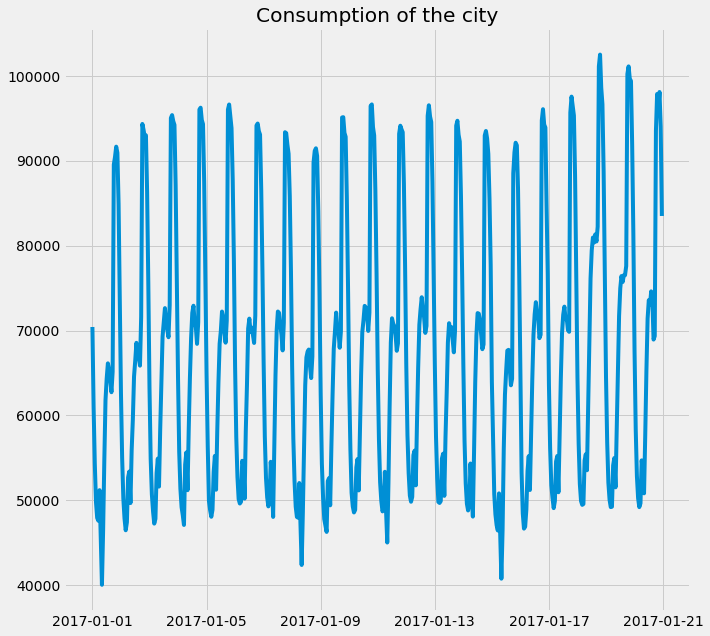

In [6]:
p=plt.plot(data)
plt.title("Consumption of the city")
plt.savefig("output.jpg")

<p> Preparing test Data like we did for the training data</p>

<p> Preparing Training and Testing Set </p>

In [39]:
# Testing Data
testdata=data[432:480]
#Training Data
traindata=data[0:432]


<p> Visualizing the time series</p>

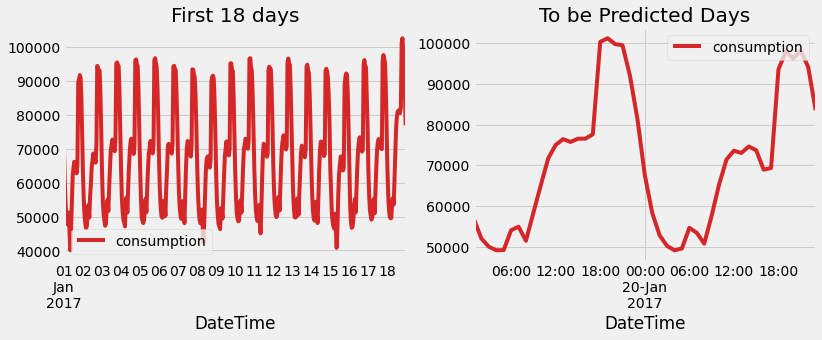

In [8]:
ax1 = plt.subplot(121)
traindata.plot(figsize=(12,4) ,color="tab:red", title="First 18 days", ax=ax1);
ax2 = plt.subplot(122)
testdata.plot(color="tab:red", title="To be Predicted Days", ax=ax2);


<p> Trend Seasonality Plot </p>

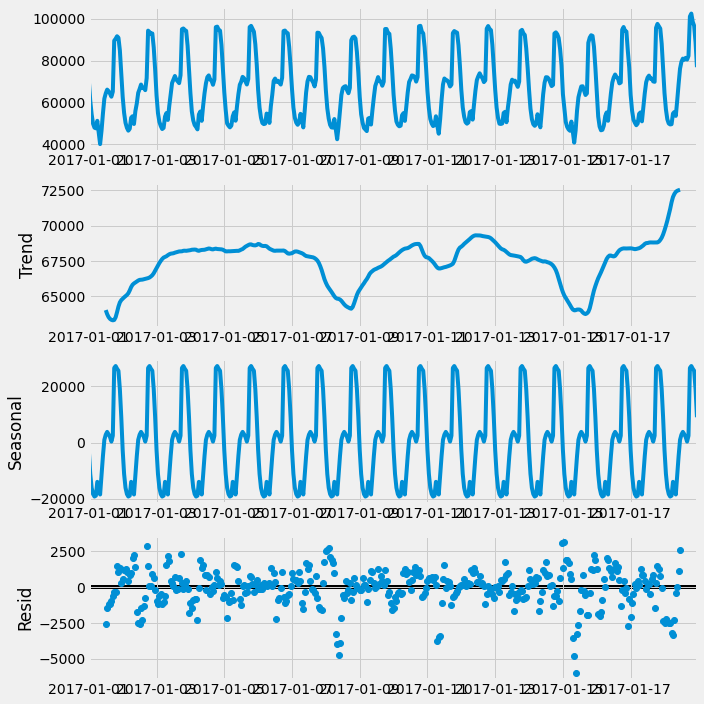

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(traindata,model='additive',freq=24)
result.plot()
plt.show()

<p> Checking for stationarity of the data</p>

In [64]:
from statsmodels.tsa.stattools import adfuller
X=traindata.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
result


ADF Statistic: -7.904235
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


(-7.904234577577816,
 4.107308909685029e-12,
 18,
 413,
 {'1%': -3.4462831955497135,
  '5%': -2.8685636962704395,
  '10%': -2.5705114078759914},
 8073.366668446108)

<p> As the p-value is 0 and the adf statistics is high negative number, we can reject the null hypothesis and can conclude that our data is stationary

    Also from the graphs for seasonality and trends, we can see that there is no trend in the data, aslo seasonality is uniform
</p>

<p> Looking More into the data calculating the rolling Mean and Standard Deviation </p>

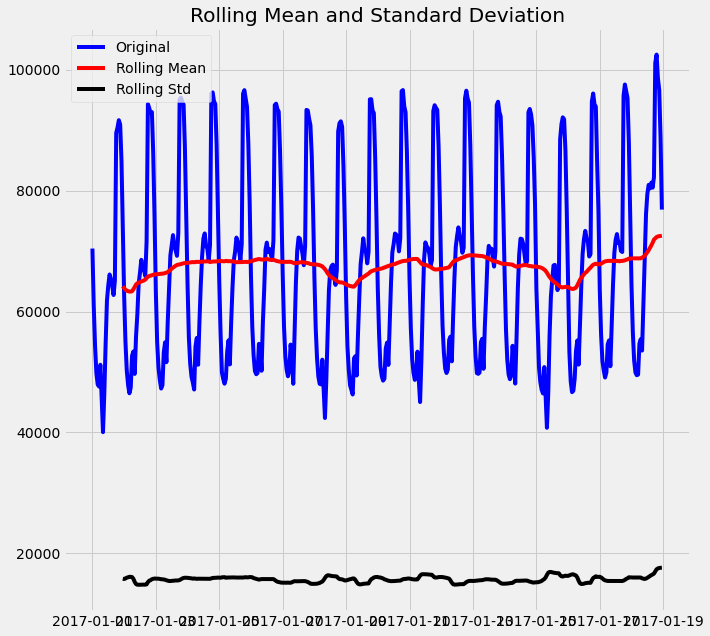

Results of dickey fuller test
Test Statistics               -7.904235e+00
p-value                        4.107309e-12
No. of lags used               1.800000e+01
Number of observations used    4.130000e+02
critical value (1%)           -3.446283e+00
critical value (5%)           -2.868564e+00
critical value (10%)          -2.570511e+00
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['consumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(traindata)


<p> We will be using the ARIMA model to fit the data for future predictions, to do that we have to calculate the ACF and PACF plots to get the arguments for the ARIMA function</p>

<p> Plots for ACF and PACF </p>

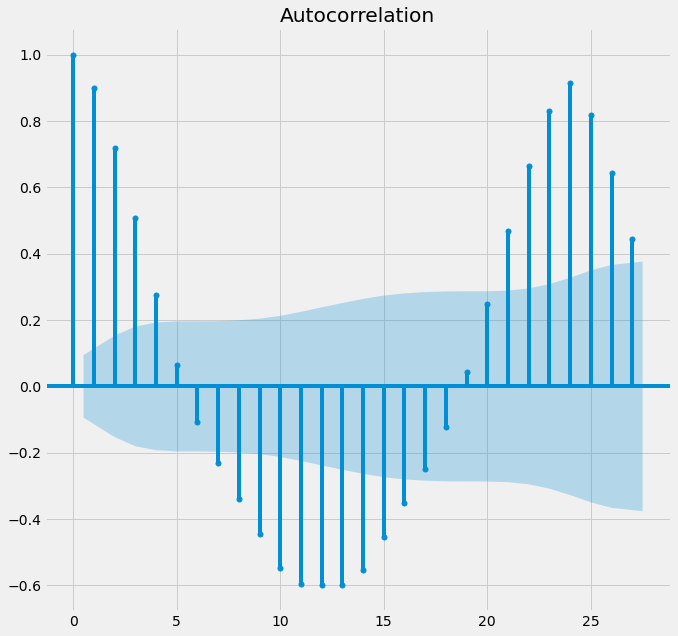

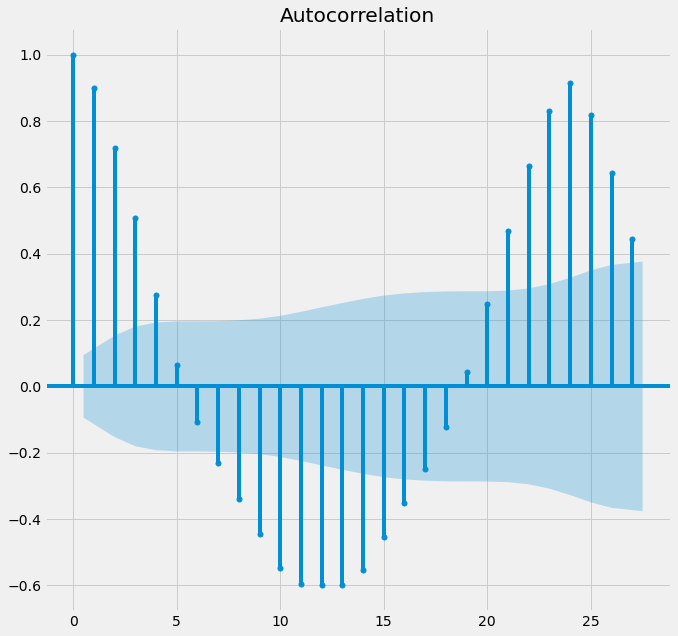

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(traindata)

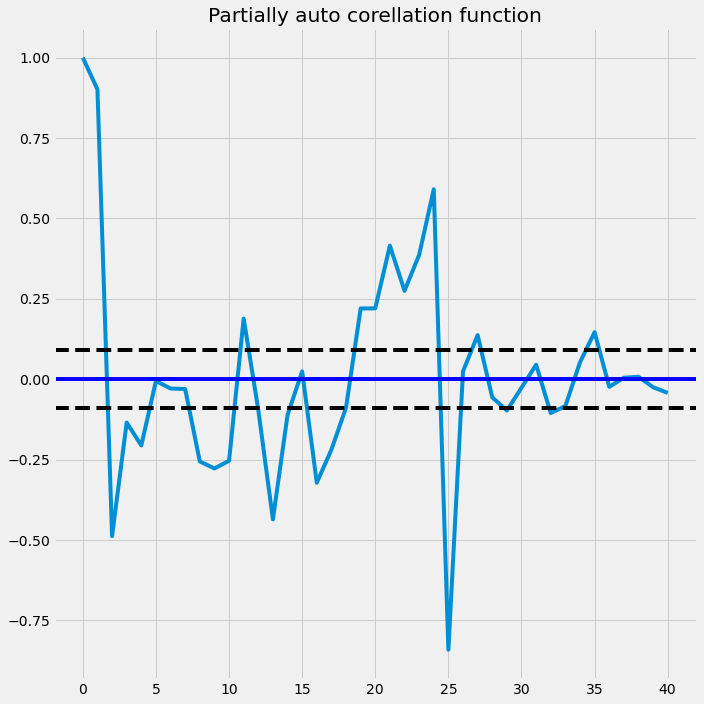

In [13]:
from statsmodels.tsa.stattools import acf,pacf
pacf= pacf(traindata,method='ols')#plot PACF
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

In [24]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(traindata, order=(4,0,2))
result_AR = model.fit(disp = 0)
plt.plot(data)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-traindata["consumption"])**2))


ImportError: cannot import name 'SARIMA' from 'statsmodels.tsa.arima_model' (/Users/sanket/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py)

/Users/sanket/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/sanket/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/sanket/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RSS : 10301334452.745804


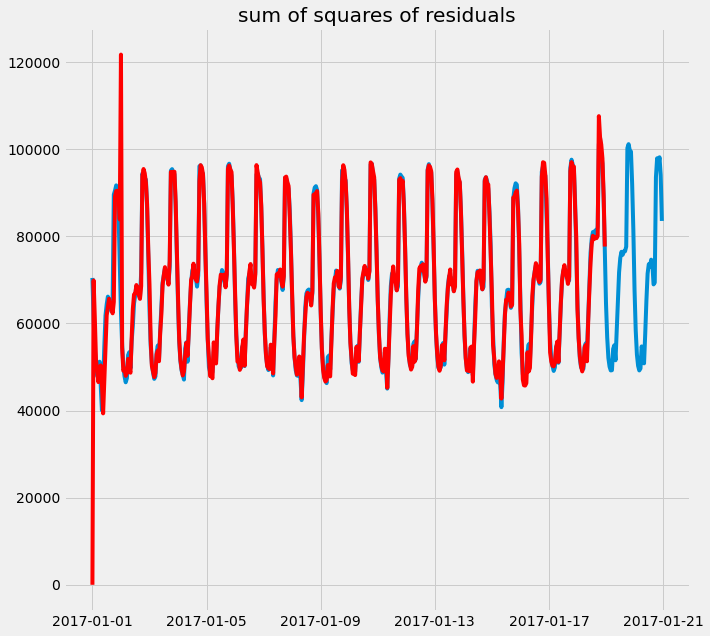

In [75]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(traindata, order=(2,1,4), seasonal_order=(1,1,1,24))
result_AR = model.fit(disp = 0)
plt.plot(data)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-traindata["consumption"])**2))

<p>Forecasting for the next two days</p>

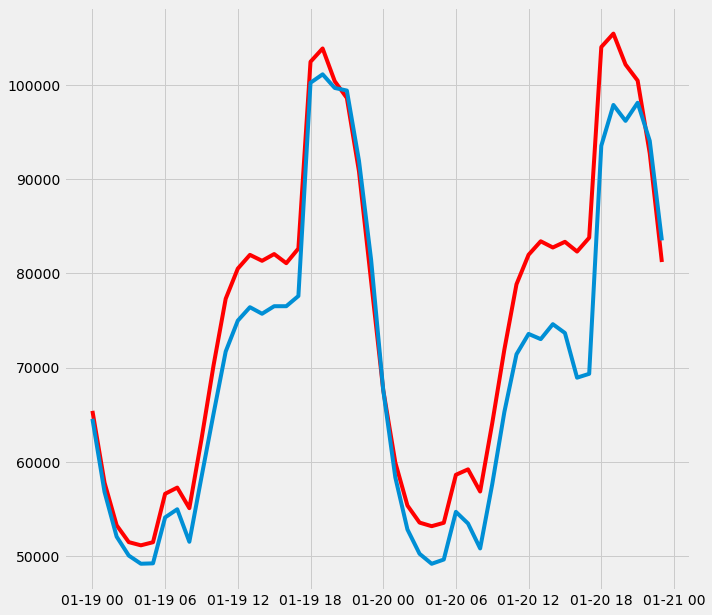

In [71]:
forecast= result_AR.forecast(steps=48)
p=testdata[['consumption']].to_numpy()
plt.plot(forecast,color='red')
plt.plot(testdata)

<p>Plotting in the actual graph</p>


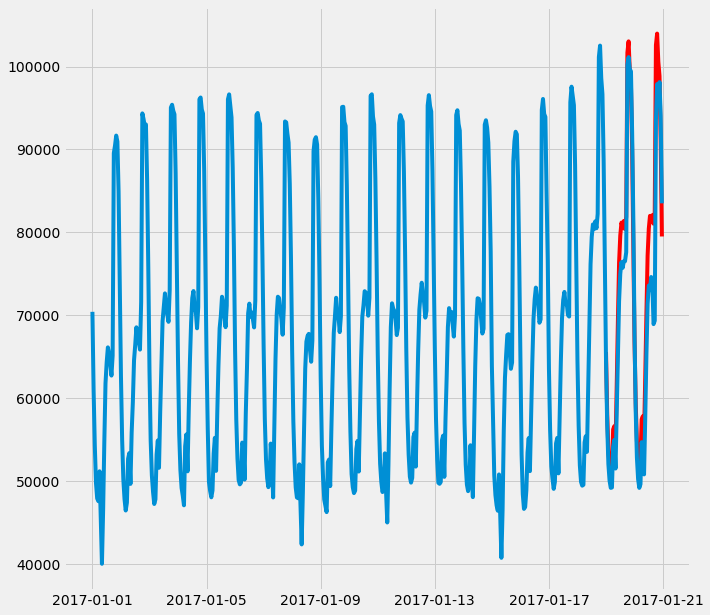

In [67]:
plt.plot(forecast,color='red')
plt.plot(data)

In [47]:
resid= pd.DataFrame(testdata['consumption']-forecast.values)

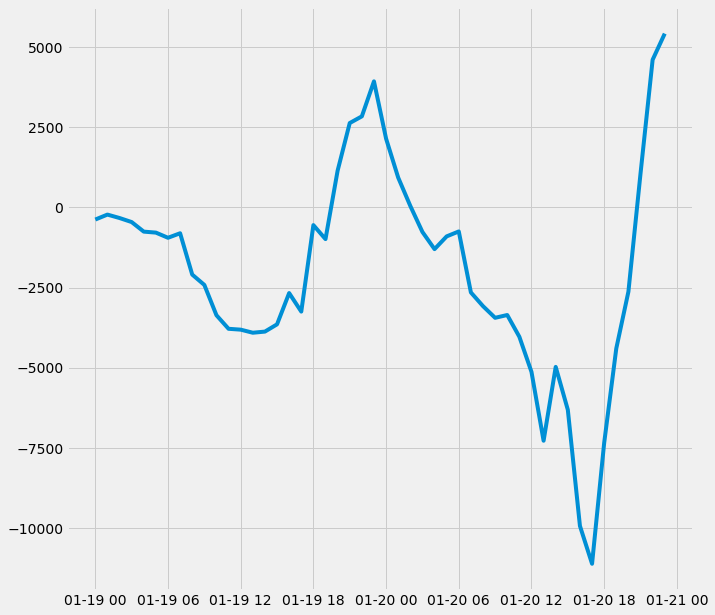

In [60]:
plt.plot(resid.index,resid.values)